<h1>Example: Transverse Field Ising Model</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:

###
### General imports
###

#import time

import numpy              as np
import numpy.linalg       as la
import scipy.integrate    as spi
import matplotlib.pyplot  as plt


###
### Operator simulation & Hamiltonian
### preperation imports
###
from pyLIQTR.sim_methods.simqsp             import SimQSP
import pyLIQTR.sim_methods.quantum_ops        as     qops    


###
### Ploting and text output settings
###

np.set_printoptions(precision=2)



<hr>

The `pyLIQTR` suite can handle quantum simualtion  for any $k$-local Hamiltonian that is specified in terms of Pauli strings.  These models can be mapped onto some variant of a Heisenberg Hamiltonian,


\begin{equation}
H =  \sum_{\langle j,k \rangle} \left[ J^x_{j,k} (X_{j} \otimes X_{k}) + J^y_{j,k}  (Y_j \otimes Y_{k}) + 
J^z_{j,k} (Z_j  \otimes  Z_{k}) \right] + 
\sum_j \left[ h^{x}_j X_j + h^{y}_j Y_j +  h^{z}_j Z_j \right], 
\end{equation}

where $\{X_j, Y_j, Z_j\}$ are Pauli spin operators acting on site (vertex) $j$ of some lattice (graph).  This construction assumes that there is a single spin at each lattice site (vertex), with the notation $\langle j,k \rangle$ used to denote a summation over  pairs of these sites.  It is immediately clear that there are two key components to this model: a set of pairwise couplings (e.g., $X_{j} \otimes X_{k}$) between spins on sites $j$ and $k$, and a set of local fields  (e.g., $X_j$) at each spin site. The real constants $J^{x (y,z)}_{j,k}$ and $h^{x (y,z)}_j$ reflect the strengths of these interactions.  A slightly more subtle $-$ but equally important $-$ fact is that these pairwise interactions can be defined for a system of any spatial dimensionality or lattice geometry.

In this notebook, we will consider an especially interesting 1-$d$ limit of the Heisenberg Hamiltonian, which has only a homogeneous $z$-coupling  and local $z$- and $x$-fields.  This <i>Transverse-Field Ising Model</i> serves as a prototype for a broad range of physics, including quantum phase transitions, non-interacting Fermions, and integrable spin systems.

<h2><u>Transverse-Field Ising Model</u></h2>
<h3>Background</h3>

The one-dimensional transverse-field Ising model (TFIM) has a rich phase diagram,  which includes a distinctive quantum phase transition (QPT) between ordered and disordered regimes.  This system is described by the Hamiltonian,


\begin{equation}
H = \sum_{j=0}^{N-1}  J^z \left(Z_j  \otimes  Z_{j+1}\right)  +  \sum_{j=0}^N \left(h^x X_j + g^x Z_j\right),
\end{equation}

which is integrable when either $h^x = 0$ or $h^z = 0$ (but not both simultaneously).  It should be noted that some authors adopt the term "tilted-field" for the above case, while reserving  "transverse-field" for the $h^z = 0$ limit alone.  This integrability has facilitated an extensive characterization, leading the TFIM to become a  textbook-level prototype for QPTs.  Moreover, a two-dimensional variant of this model with inhomogeneous couplings and fields can describe the current generation of quantum annealing platforms, though this requires a parametric scaling of the $X$ (decreasing) and $Z$ (increasing) containing terms during the adiabatic evolution. While significant in its own right, the TFIM is just a limit of the Heisenberg Hamiltonian without $Y$ fields or $XX$ / $YY$ coupling.


For spin-1/2 systems the sign of $J^z$ determines if ferromagnetic ($J^z < 0$) or antiferromagnetic  ($J^z > 0$) order will be present.  This model exhibits interesting features aside from its integrability, including a $\mathbb{Z}_2$ symmetry associated with flipping the $z$ component of every spin within the lattice (<i>i.e.</i>, via the operation $\mathcal{X} = \bigotimes_{j=0}^N X_j$, which commutes with $H$).  When $h^x = 0$ the ground state corresponds to a pair of degenerate broken symmetry configurations, irrespective of the spin-spin coupling:


\begin{equation}
\psi_0 \sim \begin{cases}
|\uparrow \uparrow \dots \uparrow \uparrow \rangle  \,\,\, \text{or} \,\,\, |\downarrow \downarrow \dots \downarrow \downarrow \rangle & \text{when} \,\,\, J < 0 \\
|\uparrow \downarrow \dots \uparrow \downarrow \rangle  \,\,\, \text{or} \,\,\, |\downarrow \uparrow \dots \downarrow \uparrow \rangle & \text{when} \,\,\, J > 0.
\end{cases}
\end{equation}

The TFIM also has a one-to-one correspondence  between ferromagnetic and antiferromagnetic orders, giving an identical phase diagram for either sign of  $J^z$. 

The presence of noncommuting operators $[X,Z] \neq 0$ is what delivers a distinctly quantum flavor.  Notably, as $|h^x| \rightarrow \infty$, we find that the ground state $\psi_0$ approaches either the state $\mid\rightarrow\rangle = 2^{-N}\bigotimes_{j=0}^N (\mid\uparrow\rangle + \mid\downarrow\rangle)$ or the state $\mid\leftarrow\rangle = 2^{-N}\bigotimes_{j=0}^N (\mid\uparrow\rangle - \mid\downarrow\rangle)$ depending on the sign of $h^x$.  These are invariant under the action of $\mathcal{X}$, implying a nondegenerate state with unbroken symmetry.  The ratio $\mid h^x / J^z \mid$ quantifies scaling between these regimes, with our promised quantum critical point separating them when $\mid h^x / J^z \mid = 1$.

We will now describe how to perform quantum simulations of an antiferromagnetic TFIM in this quantum critical regime. 

<i><b>Note:</b></i> The number of spins $N$ will define the quantum computational scale of our problem.  While the quantum critical regime is integrable $-$ and thus simulatable in polynomial time using specific methods $-$ the TFIM is non-integrable for most parameter choices and remains classically challenging.  This means that our hardness and resource overheaed are formally independent of the fields and couplings, though the latter can define special cases where the problem becomes classically  tractable.

<h3>Generating the TFIM Hamiltonian</h3>

We begin by defining the Hamiltonian for an $N = 4$ site antiferromagnetic TFIM with $\mid h^x / J^z\mid = 1$, though $N$ can be increased to generate more challenging instances.  This quantum critical regime is specified as:

In [2]:

N    =   4;        J_z  =   1.0;          h_x  =  -1.0


 PyLIQTR provides a `params_heisenberg_1d` method within the `quantum_ops` module.  This routine can generate inpupt parameter sets for a range of Heisenberg-type models:

In [3]:

tuples,types,coeffs = qops.params_heisenberg_1d(N,J_z=J_z,h_x=h_x,periodic=False)


Note that there is also an optional keyword argument `periodic` which allows us to generate a Hamiltonian with periodic boundary conditions. The returned objects describe this Hamiltonian: `tuples` enumerates the lattice sites which are coupled,  `types` describes the nature of these couplings, and the corresponding coefficients are placed into `coeffs`.  For this example:


In [4]:

print("\nSites     \t Type \t\t Coefficient\n",end="")
print("-"*50,"\n")
for j in range(len(tuples)):
    print(tuples[j],"\t\t", types[j], "\t\t", coeffs[j])
print("")



Sites     	 Type 		 Coefficient
-------------------------------------------------- 

(0, 1) 		 ZZ 		 1.0
(1, 2) 		 ZZ 		 1.0
(2, 3) 		 ZZ 		 1.0
0 		 X 		 -1.0
1 		 X 		 -1.0
2 		 X 		 -1.0
3 		 X 		 -1.0



which corresponds to the four-site TFIM Hamiltonian:


\begin{split}
H &= \sum_{j=0}^{2} \left[ J^z_{j} (Z_j  \otimes  Z_{j+1}) \right] +  \sum_{j=0}^3 h_j Z_j \\
& = (Z_0 \otimes Z_1 + Z_1 \otimes Z_2 + Z_2 \otimes Z_3) - (X_0 + X_1 + X_2 + X_3)
\end{split}


<i><b>Generating Pauli Strings<b></i>
    
The circuit preparation routines in `pyLIQTR` require that we specify Pauli strings as input. An isolated set of these can be produced by passing the preceding output the `ps_text_full_set` function:

In [5]:

tuples_full = qops.ps_text_full_set(tuples,types,N)


In [6]:
print("\nStrings     \n",end="")
print("-"*50,"\n")
for j in range(len(tuples)):
    print(tuples_full[j])
print("")


Strings     
-------------------------------------------------- 

ZZII
IZZI
IIZZ
XIII
IXII
IIXI
IIIX




Conspicuously absent are numerical values for the couplings and fields, which will also be to generate circuits.  We can generate more pertinent output by passing the coefficients as a keyword argument to `ps_text_full_set`:


In [7]:

ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs)
ham_strings


[('ZZII', 1.0),
 ('IZZI', 1.0),
 ('IIZZ', 1.0),
 ('XIII', -1.0),
 ('IXII', -1.0),
 ('IIXI', -1.0),
 ('IIIX', -1.0)]

The resulting array of tuples can be used directly with `pyLIQTR`'s circuit generation code.

<b><i>Generating a Hamiltonian Matrix</i></b>

The Pauli string tuples can also be used to generate a matrix representation of the Hamiltonian, which is particularly useful for classical reference simulations.  This is accomplished by invoking  the `ham_from_pauli_tuples` routine:

In [8]:

H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)


<h3>Classical Simulation</h3>


Although our goal is to generate circuits for quantum simulation, it is helpful to have some classical reference values on hand as a sanity check.  To this end, we can use the Hamitonian matrix $H$ that was generated by `ham_from_pauli_tuples` to numerically integrate the TFIM following a field quench.  We begin by setting some initial parameters:

In [9]:

dt            =  0.05                            # Integration timestep, Decrease this 
                                                 #   if you'd like a finer grain simulation
tmax          =  16.0                            # Maximal timestep
sclf          =  1                               # Scale factor for timestep sampling
N_ts          =  int(np.ceil(tmax/dt))           # Total number of timesteps
timestep_vec  =  np.arange(0,tmax+dt,sclf*dt)    # Define array of timesteps


Next, we build up the initial wavefunction as a spin-up product state $\mid\psi_0\rangle = \bigotimes_{j=0}^{N-1} \mid \uparrow\rangle$ so that:

In [10]:

psi0 = qops.multikron([qops.sz_u]*N)             # Generate the wavefunction as a 
psi0 = psi0 / la.norm(psi0)                      # Kronecker product and normalize it.

psi0_vec = qops.vectorize_cvec(psi0)             # Vectorize the initial wavefunction



We can verify the local expectation value of $Z_j$ on each site of the lattice:


In [11]:

print(qops.measure_obs_site(psi0,qops.pz).real)


[1. 1. 1. 1.]


The derivative $\partial_t \mid\psi\rangle = -\imath H \mid \psi\rangle$ is given by the function `prop_wfn` in the `quantum_ops` module.  This allows us to use ODEPACK methods to integrate the wavefunction: 

In [12]:

traj_raw_wfn = spi.odeint(qops.prop_wfn,psi0_vec,timestep_vec,args=(H,),atol=1e-16)


There is also a method `parse_wfn_traj` which can evaluate a single qubit observable on every qubit for every timestep in the trajectory (or, alternatively, an N-qubit observable for every timestep).  We evaluate this for the spin-up projector `przp` $= (1 + Z)/2$:

In [13]:

traj_proc_wfn = qops.parse_wfn_traj(timestep_vec,traj_raw_wfn,qops.przp)

obs_reference = traj_proc_wfn[:,1:(N+1)].real

Finally, we plot the time evolution of our observable:

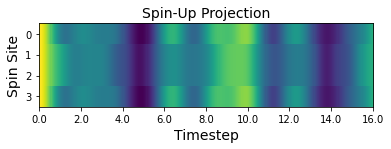

In [14]:

N_ticks = 8

aspect = 1/0.05

plt.imshow(np.transpose(obs_reference),
           cmap='viridis', interpolation='nearest', aspect=aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)


plt.xticks(np.arange(0,N_ts+1,N_ts/N_ticks),labels=np.arange(0,tmax+dt,int(tmax/N_ticks)))
plt.show()


The mean spin projection at each timepoint should immediately look  familiar to anyone who has studied this model:

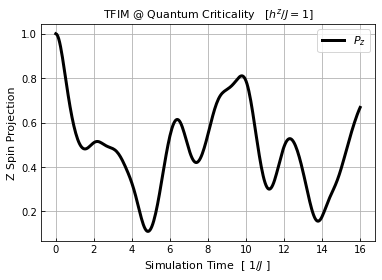

In [15]:

prpz_mean_data = np.mean(np.transpose(obs_reference),0)
xvec           = np.linspace(0,16,num=len(prpz_mean_data))

plt.plot(xvec,prpz_mean_data,linewidth=3,color='k')
plt.legend(["$P_z$","QSP"],fontsize=11)
plt.tick_params(axis='both',which='both',direction='in')
plt.xlabel('Simulation Time  [ $1/J$ ]',fontsize=11)
plt.ylabel('Z Spin Projection',fontsize=11)
plt.title('TFIM @ Quantum Criticality   $[h^z / J = 1]$',fontsize=11)
plt.grid()
